## 2. Import

In [3]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler, Normalizer

from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression, Ridge, BayesianRidge, Lasso, SGDRegressor, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.pipeline import make_pipeline

import plotly.offline as py

In [5]:
from IPython.core.display import HTML
HTML("""
<style>
.p-Widget.jp-RenderedImage.jp-mod-trusted.jp-OutputArea-output {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

### 4 Algortihmic Regression Model

#### Functions

In [4]:
def kbest(df, target_tic_stock, k=100):
    """
    Input:
        * DataFrame from where to get train data
        * target tic stock (ex. ("AAPL", "Close"))
        * k; number of top features to select (default = 100)
        * RETURNS: featureScores and y
    """
    X = df.iloc[:,np.where(df.columns != target_tic_stock)[0]]
    y = df[target_tic_stock].values

    bestfeatures = SelectKBest(score_func=f_regression, k=k)
    fit = bestfeatures.fit(X,y)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(X.columns)
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['Specs','Score']
   
    return featureScores, y

def reg_hyper_params(model, target_tic, X, y, datain, tscv,ts):
    global results_grid

    if model == 'bayridge_reg':
        estimator = BayesianRidge()
        alpha_init = [0.01, 0.1, 1, 10]
        lambda_init = [0.01, 0.1, 1, 10]
        param_grid = dict(alpha_init=alpha_init, lambda_init=lambda_init)        
        grid = GridSearchCV(estimator = estimator, param_grid = param_grid, scoring = "r2", n_jobs = -1, cv = tscv, return_train_score = True)
        results_grid[(target_tic,model,datain,ts)] = grid.fit(X,y).best_params_
        return grid.fit(X,y)

    elif model == 'ridge_reg':
        estimator = Ridge()
        alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
        param_grid = dict(alpha=alpha)
        grid = GridSearchCV(estimator = estimator, param_grid = param_grid, scoring = "r2", n_jobs = -1, cv = tscv, return_train_score = True)
        results_grid[(target_tic,model,datain,ts)] = grid.fit(X,y).best_params_
        return grid.fit(X,y)
    
    elif model == 'lasso_reg':
        estimator = Lasso()
        alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
        param_grid = dict(alpha = alpha)
        grid = GridSearchCV(estimator = estimator, param_grid = param_grid, scoring = "r2", n_jobs = -1, cv = tscv, return_train_score = True)
        results_grid[(target_tic,model,datain,ts)] = grid.fit(X,y).best_params_
        return grid.fit(X,y)
    
    elif model == 'elastic_reg':
        estimator = ElasticNet()
        alpha = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
        l1_ratio = [np.round(0.2*y,1) for y in range(0,6)]
        param_grid = dict(alpha = alpha, l1_ratio = l1_ratio)
        grid = GridSearchCV(estimator = estimator, param_grid = param_grid, scoring = "r2", n_jobs = -1, cv = tscv, return_train_score = True)
        results_grid[(target_tic,model,datain,ts)] = grid.fit(X,y).best_params_
        return grid.fit(X,y)
    
    elif model == 'svm_reg':
        estimator = SVR()
        kernel = ['linear', 'poly', 'rbf', 'sigmoid']
        C = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
        degree = [2,3]
        param_grid = dict(kernel = kernel, C = C, degree = degree)
        grid = GridSearchCV(estimator = estimator, param_grid = param_grid, scoring = "r2", n_jobs = -1, cv = tscv, return_train_score = True)
        results_grid[(target_tic,model,datain,ts)] = grid.fit(X,y).best_params_
        return grid.fit(X,y)
    
    elif model == 'sdg_reg':
        estimator = SGDRegressor()
        alpha = [0.001, 0.01, 0.1, 1, 10, 100]
        l1_ratio = [np.round(0.2*y,1) for y in range(0,6)]
        learning_rate = ["constant", "optimal", "invscaling", "adaptive"]
        eta0 = [0.001, 0.01, 0.1, 1, 10]
        param_grid = dict(alpha = alpha, l1_ratio = l1_ratio, learning_rate = learning_rate, eta0 = eta0)
        grid = GridSearchCV(estimator = estimator, param_grid = param_grid, scoring = "r2", n_jobs = -1, cv = tscv, return_train_score = True)
        results_grid[(target_tic,model,datain,ts)] = grid.fit(X,y).best_params_
        return grid.fit(X,y)
    
    elif model == 'tree_reg':
        estimator = DecisionTreeRegressor()
        max_depth = [y for y in range(1,16)]
        param_grid = dict(max_depth = max_depth)
        grid = GridSearchCV(estimator = estimator, param_grid = param_grid, scoring = "r2", n_jobs = -1, cv = tscv, return_train_score = True)
        results_grid[(target_tic,model,datain,ts)] = grid.fit(X,y).best_params_
        return grid.fit(X,y)
    
    elif model == 'ranforest_reg':
        estimator = RandomForestRegressor(n_jobs = -1)
        max_depth = [y for y in range(1,16)]
        param_grid = dict(max_depth = max_depth)
        grid = GridSearchCV(estimator = estimator, param_grid = param_grid, scoring = "r2", n_jobs = -1, cv = tscv, return_train_score = True)
        results_grid[(target_tic,model,datain,ts)] = grid.fit(X,y).best_params_
        return grid.fit(X,y)

    elif model == 'poly_reg':
        estimator = make_pipeline(PolynomialFeatures(), LinearRegression(n_jobs = -1))
        param_grid = {'polynomialfeatures__degree': range(2,4)}
                      # 'linearregression__fit_intercept': [True, False], 'linearregression__normalize': [True, False]}
        grid = GridSearchCV(estimator, param_grid = param_grid, scoring = "r2", n_jobs = -1, cv = tscv, return_train_score = True)
        results_grid[(target_tic,model,datain,ts)] = grid.fit(X,y).best_params_
        return grid.fit(X,y)
    
    elif model == 'knei_reg':
        estimator = KNeighborsRegressor(n_jobs = -1)
        n_neighbors = [y for y in range(1,20)]
        param_grid = dict(n_neighbors = n_neighbors)
        grid = GridSearchCV(estimator = estimator, param_grid = param_grid, scoring = "r2", n_jobs = -1, cv = tscv, return_train_score = True)
        results_grid[(target_tic,model,datain,ts)] = grid.fit(X,y).best_params_        
        return grid.fit(X,y)
    
    else:
        print("No regression model selected")

def test_size_opt_reg(X, y, target_tic, model, datain, n_features):
    global results_reg_df
    
    test_size_porc = [np.round(0.05*x,2) for x in range(1,8)]
    for ts in test_size_porc:
        n_splits = int(np.trunc(X.shape[0]/int(X.shape[0]*ts)))
        test_size = int(X.shape[0]*ts)
        tscv = TimeSeriesSplit(n_splits = n_splits, gap = 0, test_size = test_size-1)
        
        if model == "lin_reg":
            estimator = LinearRegression()
            ind = X.shape[0]-int(X.shape[0]*ts)
            X_train, X_test = X[:ind,:], X[ind:,:]
            y_train, y_test = y[:ind], y[ind:]
            estimator.fit(X_train,y_train)
            results_reg_df.loc[(target_tic,model,datain, n_features, ts, n_splits),:] = (np.round(r2_score(y_train,estimator.predict(X_train)),2),
                                                                           0,
                                                                           0,
                                                                           np.round(r2_score(y_test,estimator.predict(X_test)),2),
                                                                           0,
                                                                           0)             
        else:    
            grid_fit = reg_hyper_params(model, target_tic, X, y, datain, tscv,ts)
            results_reg_df.loc[(target_tic,model,datain, n_features, ts, n_splits),:] = (np.round(grid_fit.cv_results_[f'split{n_splits-1}_train_score'][grid_fit.best_index_],2),
                                                                           np.round(grid_fit.cv_results_['mean_train_score'][grid_fit.best_index_],2),
                                                                           np.round(grid_fit.cv_results_['std_train_score'][grid_fit.best_index_],2),
                                                                           np.round(grid_fit.cv_results_[f'split{n_splits-1}_test_score'][grid_fit.best_index_],2),
                                                                           np.round(grid_fit.cv_results_['mean_test_score'][grid_fit.best_index_],2),
                                                                           np.round(grid_fit.cv_results_['std_test_score'][grid_fit.best_index_],2))                                                                    
    return results_reg_df

#### Header

In [6]:
results_grid = dict() # Grid Search results

# Cross Validation results and Timeseries split optimization results
results_reg_df = pd.DataFrame(index = pd.MultiIndex.from_arrays([["ticker"],["model"],["datain"],["n_features"],["test_size_prop"], ["n_splits"]]), 
                    columns = pd.MultiIndex.from_product([["train","test"], ["score", "mean_scorecv","std_scorecv"]])).iloc[1:,:]
results_reg_df.index.names = ["ticker","model","datain","n_features", "test_size_prop", "n_splits"]

In [7]:
## DATA
df = data2y_ret
datain = "rets"

## REGRESSION MODELS TO CONSIDER
# models = np.array(['lin_reg', 'ridge_reg', 'lasso_reg', 'elastic_reg', 'svm_reg', \
#          'sdg_reg', 'bayridge_reg', 'tree_reg', 'ranforest_reg', 'poly_reg', 'knei_reg'])
models = np.array(['lin_reg', 'ridge_reg', 'lasso_reg', 'elastic_reg', 'bayridge_reg', 'tree_reg'])

## MODEL SELECTION
corr_selection = True
ncoef = np.array([np.round((x+0.05),2) for x in np.arange(0.5,0.85,0.05)])
matcorr = matcorr_data2y_ret

kbest_selection = True
nkbest = 4

scaling = True
scalers = [StandardScaler(), MinMaxScaler(), Normalizer(),"nosc"]

## ML ALGORITHM
regression = True
scoring = ["r2"]

#### Main

#### Export Algortihmic Regression Model Results to Parquet

#### Import Algortihmic Regression Model Results to Parquet

In [56]:
##IMPORT PARQUET

results_reg_df = pd.read_parquet("export/ML_algo_reg_res/results_reg_df.gzip")
best_models = pd.read_parquet("export/ML_algo_reg_res/best_models.gzip")
best_models1 = pd.read_parquet("export/ML_algo_reg_res/best_models1.gzip") 
to_improve = pd.read_parquet("export/ML_algo_reg_res/to_improve.gzip")
results_grid2 = pd.read_parquet("export/ML_algo_reg_res/results_grid2.gzip")
results_grid = results_grid2.to_dict(orient="index")

### Algorithmic Regression Models Results

In [57]:
results_reg_df.loc[results_reg_df.index.get_level_values(1).str.contains("tree")]

train  \
                                                                        score   
ticker model    datain               n_features test_size_prop n_splits         
AAPL   tree_reg rets_corr0.55_scStan 133        0.05           20        0.83   
                                                0.10           10        0.92   
                                                0.15           6         0.76   
                                                0.20           5         0.76   
                                                0.25           4         0.76   
...                                                                       ...   
TSLA   tree_reg rets_kbest201_nosc   201        0.15           6         0.85   
                                                0.20           5         0.89   
                                                0.25           4         0.84   
                                                0.30           3         0.69   
                                                0.35           2         0.85   

                                                                                      \
                                                                        mean_scorecv   
ticker model    datain               n_features test_size_prop n_splits                
AAPL   tree_reg rets_corr0.55_scStan 133        0.05           20               0.88   
                                                0.10           10               0.95   
                                                0.15           6                0.80   
                                                0.20           5                0.83   
                                                0.25           4                0.84   
...                                                                              ...   
TSLA   tree_reg rets_kbest201_nosc   201        0.15           6                0.88   
                                                0.20           5                0.93   
                                                0.25           4                0.90   
                                                0.30           3                0.77   
                                                0.35           2                0.88   

                                                                                     \
                                                                        std_scorecv   
ticker model    datain               n_features test_size_prop n_splits               
AAPL   tree_reg rets_corr0.55_scStan 133        0.05           20              0.05   
                                                0.10           10              0.03   
                                                0.15           6               0.06   
                                                0.20           5               0.09   
                                                0.25           4               0.10   
...                                                                             ...   
TSLA   tree_reg rets_kbest201_nosc   201        0.15           6               0.04   
                                                0.20           5               0.04   
                                                0.25           4               0.06   
                                                0.30           3               0.08   
                                                0.35           2               0.02   

                                                                         test  \
                                                                        score   
ticker model    datain               n_features test_size_prop n_splits         
AAPL   tree_reg rets_corr0.55_scStan 133        0.05           20        0.83   
                                                0.10           10        0.72   
                                                0.15           6         0.72   

In [58]:
res_reg_analysis = results_reg_df.astype(float)
res_reg_analysis.columns = res_reg_analysis.columns.map('_'.join)
res_reg_analysis = res_reg_analysis.reset_index()

## Filter of coef higher than 0.8 to filter Kbest runs
res_reg_analysis["coef"] = np.where(res_reg_analysis.datain.str.extract('([0-9][.]*[0-9]*)').astype(float)[0] > 0.8,
         0, res_reg_analysis.datain.str.extract('([0-9][.]*[0-9]*)')[0]).astype(float)

res_reg_analysis["scaling"] = res_reg_analysis.datain.str.split("_", expand = True)[2]
res_reg_analysis = res_reg_analysis.iloc[:,[0,1,-2,-1,3,4,6,7,8,9,10,11]]

In [59]:
res_reg_analysis_grp = pd.DataFrame(res_reg_analysis.groupby(["ticker","model","coef","n_features","scaling","test_size_prop"])["train_score","test_score"].mean())
res_reg_analysis_grp = res_reg_analysis_grp.reset_index()
res_reg_analysis_grp.coef = res_reg_analysis_grp.coef.astype(float)

In [60]:
res_reg_analysis_grp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6720 entries, 0 to 6719
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ticker          6720 non-null   object 
 1   model           6720 non-null   object 
 2   coef            6720 non-null   float64
 3   n_features      6720 non-null   int64  
 4   scaling         6720 non-null   object 
 5   test_size_prop  6720 non-null   float64
 6   train_score     6720 non-null   float64
 7   test_score      6720 non-null   float64
dtypes: float64(4), int64(1), object(3)
memory usage: 420.1+ KB


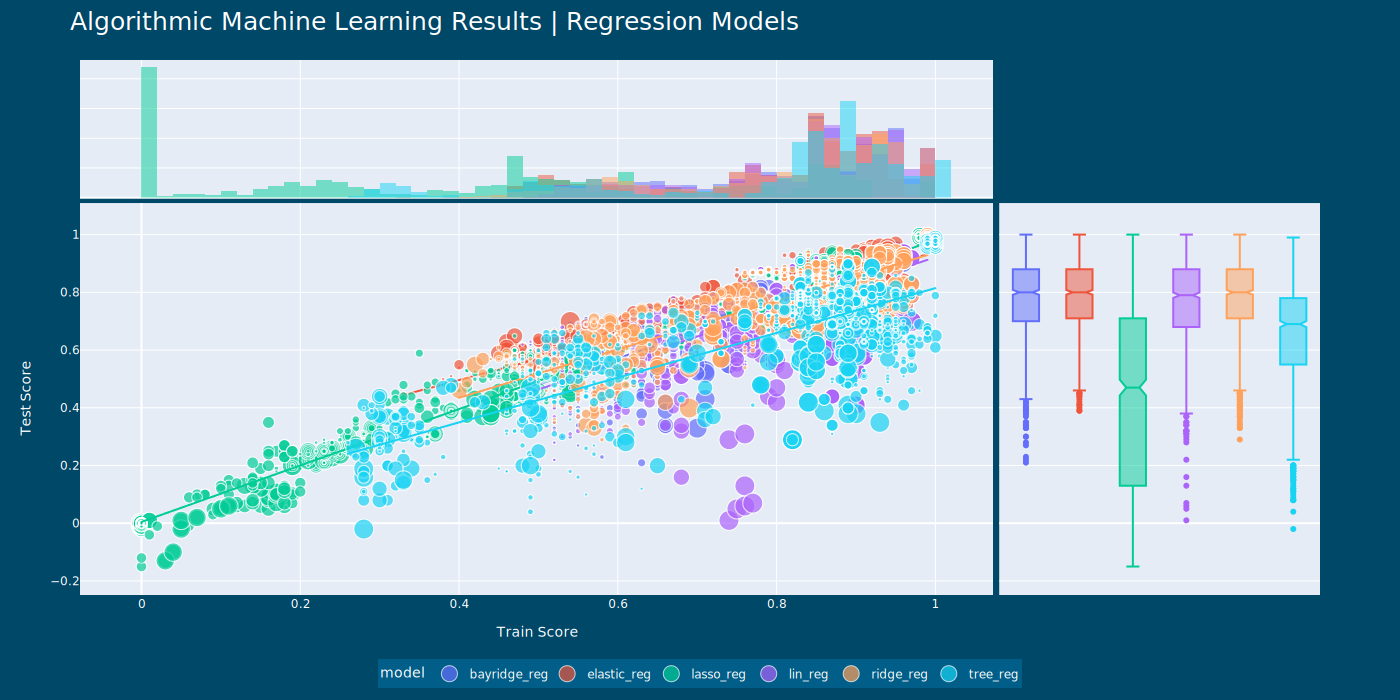

In [631]:
fig = px.scatter(res_reg_analysis_grp, x = "train_score", y = "test_score", marginal_x = "histogram", marginal_y = "box", 
           color = "model", size = "n_features", trendline = "ols", height = 700, width = 1400)

fig.update_layout(title = "Algorithmic Machine Learning Results | Regression Models", title_font = dict(size = 25, color = "white"),
                  paper_bgcolor = '#004868',
                  xaxis = dict(title = "Train Score", titlefont = dict(color = "white"), tickfont = dict(color = "white")),
                  yaxis = dict(title = "Test Score", titlefont = dict(color = "white"), tickfont = dict(color = "white")),                  
                  legend = dict(orientation = "h", x=0.5, y=-0.12, xanchor = "auto", itemsizing = "trace", 
                                bgcolor = "#005E88", itemdoubleclick = "toggleothers",
                                font = dict(color = "white")),
                 )

# py.plot(fig, filename = "RegML_algo_results", auto_open = False)
# fig.show()
fig.show("svg")

### Best Models Prediction
#### Unpack Results Table to instantiate non trained estimator as pipelines from best models per ticker
Results are gotten from next piece of code are:
* *estimator* dictionary, which keys are the models and its values are pipelines with best settings.
* *X_train, X_test* dictionary, which keys are the tickers and its values are feature arrays with best split sizes.
* *y_train, y_test* dictionary, which keys are the tickers and its values are target arrays with best split sizes.
* *sc* dictionary, which keys are the tickers and its values are the best scalers methods.

In [626]:
X = dict()
y = dict()
sc = dict()
X_train = dict()
X_test = dict()
y_train = dict()
y_test = dict()
estimator = dict()

In [ ]:
def reg_estimator(model, target_tic, X, y, datain, results_grid,ts,sc):

    if model == 'lin_reg':
        if sc != "nosc":
            return make_pipeline(sc, LinearRegression())
        else:
            return LinearRegression()
        
    elif model == 'bayridge_reg':
        if sc != "nosc":
            return make_pipeline(sc, BayesianRidge())
        else:
            return BayesianRidge()        

    elif model == 'ridge_reg':
        if sc != "nosc":
            return make_pipeline(sc, Ridge(alpha = results_grid[(target_tic,model,datain,ts)]["alpha"]))
        else:
            return Ridge(alpha = results_grid[(target_tic,model,datain,ts)]["alpha"])
    
    elif model == 'lasso_reg':
        if sc != "nosc":
            return make_pipeline(sc, Lasso(alpha = results_grid[(target_tic,model,datain,ts)]["alpha"]))
        else:
            return Lasso(alpha = results_grid[(target_tic,model,datain,ts)]["alpha"])
    
    elif model == 'elastic_reg':
        if sc != "nosc":
            return make_pipeline(sc, ElasticNet(alpha = results_grid[(target_tic,model,datain,ts)]["alpha"], l1_ratio = results_grid[(target_tic,model,datain,ts)]["l1_ratio"]))
        else:
            return ElasticNet(alpha = results_grid[(target_tic,model,datain,ts)]["alpha"], l1_ratio = results_grid[(target_tic,model,datain,ts)]["l1_ratio"])       
    
    elif model == 'svm_reg':
        if sc != "nosc":
            return make_pipeline(sc, SVR(kernel = results_grid[(target_tic,model,datain,ts)]["kernel"], 
                      degree = results_grid[(target_tic,model,datain,ts)]["degree"],
                     C = results_grid[(target_tic,model,datain,ts)]["C"]))
        else:
            return SVR(kernel = results_grid[(target_tic,model,datain,ts)]["kernel"], 
                      degree = results_grid[(target_tic,model,datain,ts)]["degree"],
                     C = results_grid[(target_tic,model,datain,ts)]["C"])
    
    elif model == 'sdg_reg':
        if sc != "nosc":
            return make_pipeline(sc, SGDRegressor(alpha = results_grid[(target_tic,model,datain,ts)]["alpha"], l1_ratio = results_grid[(target_tic,model,datain,ts)]["l1_ratio"],
                              learning_rate = results_grid[(target_tic,model,datain,ts)]["learning_rate"], eta0 = results_grid[(target_tic,model,datain,ts)]["eta0"]))
        else:       
            return SGDRegressor(alpha = results_grid[(target_tic,model,datain,ts)]["alpha"], l1_ratio = results_grid[(target_tic,model,datain,ts)]["l1_ratio"],
                              learning_rate = results_grid[(target_tic,model,datain,ts)]["learning_rate"], eta0 = results_grid[(target_tic,model,datain,ts)]["eta0"])
    
    elif model == 'tree_reg':
        if sc != "nosc":
            return make_pipeline(sc, DecisionTreeRegressor(max_depth = results_grid[(target_tic,model,datain,ts)]["max_depth"]))
        else:
            return DecisionTreeRegressor(max_depth = results_grid[(target_tic,model,datain,ts)]["max_depth"])
    
    elif model == 'ranforest_reg':
        if sc != "nosc":
            return make_pipeline(sc, RandomForestRegressor(max_depth = results_grid[(target_tic,model,datain,ts)]["max_depth"], n_jobs = -1))
        else:
            return RandomForestRegressor(max_depth = results_grid[(target_tic,model,datain,ts)]["max_depth"], n_jobs = -1)
    
    elif model == 'poly_reg':
        if sc != "nosc":
            return make_pipeline(sc, PolynomialFeatures(degree = results_grid[(target_tic,model,datain,ts)]["polynomialfeatures__degree"]), LinearRegression())
        else:
            return make_pipeline(PolynomialFeatures(degree = results_grid[(target_tic,model,datain,ts)]["polynomialfeatures__degree"]), LinearRegression())
    
    elif model == 'knei_reg':
        if sc != "nosc":
            return make_pipeline(sc, KNeighborsRegressor(n_neighbors = results_grid[(target_tic,model,datain,ts)]["n_neighbors"], n_jobs = -1))
        else:
            return KNeighborsRegressor(n_neighbors = results_grid[(target_tic,model,datain,ts)]["n_neighbors"], n_jobs = -1)
    
    else:
        print("No regression model selected")

In [606]:
best_models1

,,,,,,train_score,train_mean_scorecv,train_std_scorecv,test_score,test_mean_scorecv,test_std_scorecv
ticker,model,datain,n_features,test_size_prop,n_splits,,,,,,
AAPL,elastic_reg,rets_corr0.55_scStan,133,0.10,10,0.92,0.95,0.03,0.96,0.87,0.06
BMW.DE,ridge_reg,rets_corr0.6_scMinM,88,0.10,10,0.92,0.93,0.05,0.84,0.82,0.04
BTC-USD,elastic_reg,rets_corr0.65_scMinM,10,0.05,20,0.75,0.78,0.06,0.88,0.70,0.14
ETH-USD,lin_reg,rets_corr0.7_scStan,10,0.05,20,0.84,0.00,0.00,0.93,0.00,0.00
GOOGL,lin_reg,rets_corr0.55_scStan,134,0.05,20,0.99,0.00,0.00,1.00,0.00,0.00
MSFT,elastic_reg,rets_corr0.55_scStan,175,0.05,20,0.94,0.96,0.02,0.96,0.87,0.05
NVDA,ridge_reg,rets_corr0.55_scStan,108,0.25,4,0.93,0.96,0.02,0.94,0.82,0.09
SHEL.L,elastic_reg,rets_corr0.55_scStan,155,0.10,10,0.94,0.97,0.02,0.84,0.84,0.07
TSLA,elastic_reg,rets_kbest134_scStan,134,0.25,4,0.84,0.91,0.06,0.79,0.60,0.13


In [627]:
for n in range(best_models1.index.size):
    target_tic = best_models1.index[n][0]
    model = best_models1.index[n][1]
    datain = best_models1.index[n][2]
    test_size_prop = float(best_models1.index[n][4])
    target_tic_stock = (target_tic,"Close")
    flag_nosc = True
    
    ## DATA
    if datain.split("_")[0] == "rets":
        df = data2y_ret
    else:
        print("There is a problem with initial df")
        
    ## MODEL SELECTION
    if datain.split("_")[1].find("corr") != -1: # CORRELATION SELECTION
        coef = float(datain.split("_")[1][datain.split("_")[1].find("0"):])
        df_corr_coef = matcorr[target_tic][(matcorr[target_tic] > coef) | (matcorr[target_tic] < -coef)]["Close"].dropna(how="all")
        ticks_corr = df_corr_coef.index.unique()
        ticks_corr = np.delete(ticks_corr,np.where(ticks_corr == target_tic_stock))
        X[target_tic] = df[ticks_corr].values
        y[target_tic] = df[target_tic_stock].values

    elif datain.split("_")[1].find("kbest") != -1: # KBEST SELECTION
        n = int(datain.split("_")[1][datain.split("_")[1].find("t")+1:])
        X[target_tic] = df.iloc[:,np.where(df.columns != target_tic_stock)[0]]  # Correlated Features truncated S steps in the end
        y[target_tic] = df[target_tic_stock].values # Target shifted S steps
        
        bestfeatures = SelectKBest(score_func=f_regression, k=n)
        fit = bestfeatures.fit(X[target_tic],y[target_tic])
        dfscores = pd.DataFrame(fit.scores_)
        dfcolumns = pd.DataFrame(X[target_tic].columns)
        featureScores = pd.concat([dfcolumns,dfscores],axis=1)
        featureScores.columns = ['Specs','Score']
        X[target_tic] = df[featureScores.nlargest(n,'Score').Specs.values].values
    else:
        print("There is a problem with model selection")
    
    ## DATA SCALING 
    for i in range(len(scalers)):
        if str(scalers[i]).find(datain.split("_")[2][2:]) == 0:
            flag_nosc = False
            sc[target_tic] = scalers[i]
    if flag_nosc:
        sc[target_tic] = "nosc"
        print(f"{target_tic} not scaled")
    
    ## ESTIMATOR INSTANTIATION
    if model.split("_")[1] == "reg":
        try:
            ## SPLITS DEFINITION
            best_ind = X[target_tic].shape[0]-int(X[target_tic].shape[0]*test_size_prop)
            X_train[target_tic], X_test[target_tic] = X[target_tic][:best_ind,:], X[target_tic][best_ind:,:]
            y_train[target_tic], y_test[target_tic] = y[target_tic][:best_ind], y[target_tic][best_ind:]
            
            ## BEST MODEL INSTANTIATION
            estimator[target_tic] = reg_estimator(model, target_tic,
                                                  X_train[target_tic], y_train[target_tic],
                                                  datain, results_grid, test_size_prop, sc[target_tic])
        except:
            print(f"There is a problem modelling {target_tic} ")

print("Done!")

Done!


In [628]:
estimator

{'AAPL': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('elasticnet', ElasticNet(alpha=0.001, l1_ratio=0.2))]),
 'BMW.DE': Pipeline(steps=[('minmaxscaler', MinMaxScaler()), ('ridge', Ridge(alpha=0.1))]),
 'BTC-USD': Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                 ('elasticnet', ElasticNet(alpha=0.001, l1_ratio=0.0))]),
 'ETH-USD': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('linearregression', LinearRegression())]),
 'GOOGL': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('linearregression', LinearRegression())]),
 'MSFT': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('elasticnet', ElasticNet(alpha=0.001, l1_ratio=0.2))]),
 'NVDA': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('ridge', Ridge(alpha=10.0))]),
 'SHEL.L': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('elasticnet', ElasticNet(alpha=0.0001, l1_ratio=1.0

In [629]:
best_models1

,,,,,,train_score,train_mean_scorecv,train_std_scorecv,test_score,test_mean_scorecv,test_std_scorecv
ticker,model,datain,n_features,test_size_prop,n_splits,,,,,,
AAPL,elastic_reg,rets_corr0.55_scStan,133,0.10,10,0.92,0.95,0.03,0.96,0.87,0.06
BMW.DE,ridge_reg,rets_corr0.6_scMinM,88,0.10,10,0.92,0.93,0.05,0.84,0.82,0.04
BTC-USD,elastic_reg,rets_corr0.65_scMinM,10,0.05,20,0.75,0.78,0.06,0.88,0.70,0.14
ETH-USD,lin_reg,rets_corr0.7_scStan,10,0.05,20,0.84,0.00,0.00,0.93,0.00,0.00
GOOGL,lin_reg,rets_corr0.55_scStan,134,0.05,20,0.99,0.00,0.00,1.00,0.00,0.00
MSFT,elastic_reg,rets_corr0.55_scStan,175,0.05,20,0.94,0.96,0.02,0.96,0.87,0.05
NVDA,ridge_reg,rets_corr0.55_scStan,108,0.25,4,0.93,0.96,0.02,0.94,0.82,0.09
SHEL.L,elastic_reg,rets_corr0.55_scStan,155,0.10,10,0.94,0.97,0.02,0.84,0.84,0.07
TSLA,elastic_reg,rets_kbest134_scStan,134,0.25,4,0.84,0.91,0.06,0.79,0.60,0.13


### Chart: Regression Machine Learning models predictions

In [394]:
def pred_df(target_tic):
    """
    1. Returns for selected ticker a "test" dataframe with the following features:
        * Close Price for test range's time (closePrice_testRange)
        * Close Returns for test range's time (closeRets_testRange)
        * Cummulated Close Returns for test range's time (closeRetsCum_testRange)
        * Predicted Cummulated Close Returns for test range's time (cumRets_prediction)
        
    2. Returns for selected ticker a "train" dataframe with the following features:        
        * Close Price for train range's time (closePrice_trainRange)
        * Close Returns for train range's time (closeRets_trainRange)
        * Cummulated Close Returns for train range's time (closeRetsCum_trainRange)
    
    3. Tickers used as features to feed the models: ticks_corr
    """
    datain = best_models1.loc[best_models1.index.get_level_values(0) == target_tic,:].index[0][2]
    coef = float(datain.split("_")[1][datain.split("_")[1].find("0"):])
    df_corr_coef = matcorr[target_tic][(matcorr[target_tic] > coef) | (matcorr[target_tic] < -coef)]["Close"].dropna(how="all")
    ticks_corr = df_corr_coef.index.unique()
    ticks_corr = np.delete(ticks_corr,np.where(ticks_corr == target_tic_stock))
    
    test_size_ind = X_test[target_tic].shape[0]
    closePrice_testRange = data[target_tic]["Close"][-test_size_ind:]
    closeRets_testRange = data2y_ret[target_tic]["Close"][-test_size_ind:]
    closeRetsCum_testRange = closeRets_testRange.cumsum()
    
    train_size_ind = X_train[target_tic].shape[0]    
    closePrice_trainRange = data[target_tic]["Close"][-train_size_ind:-test_size_ind]
    closeRets_trainRange = data2y_ret[target_tic]["Close"][-train_size_ind:-test_size_ind]
    closeRetsCum_trainRange = closeRets_trainRange.cumsum()
    
    rets_prediction = estimator[target_tic].fit(X_train[target_tic], y_train[target_tic]).predict(X_test[target_tic])
    cumRets_prediction = rets_prediction.cumsum()
    df_xpred = pd.concat([closePrice_testRange, closeRets_testRange, closeRetsCum_testRange, pd.Series(cumRets_prediction, index = closePrice_testRange.index), pd.Series(rets_prediction, index = closePrice_testRange.index)], axis=1)
    df_xpred.columns = ["closePrice_testRange","closeRets_testRange","closeRetsCum_testRange","cumRets_prediction", "rets_prediction"]
    
    df_trainData = pd.concat([closePrice_trainRange, closeRets_trainRange, closeRetsCum_trainRange], axis=1)
    df_trainData.columns = ["closePrice_trainRange", "closeRets_trainRange", "closeRetsCum_trainRange"]
    
    return df_xpred, df_trainData, ticks_corr

def ax_plot(target_tic, ax, plot_features = True):
    """
    Plot same chart of different ticker in different axes.
    Args:
        * target_tic (str): ticker to plot
        * ax (str): axes number to be plotted
        * plot_features (Boolean): flag to plot features used to train
    """
    ax.set_title(f"{target_tic} | Test Score: {np.round(r2_score(y_test[target_tic], pred_df(target_tic)[0].iloc[:,-1]),2)}", font = "consolas", fontsize = 20, pad = 15)
    first_ind = -100
    ax.plot(pred_df(target_tic)[1].iloc[first_ind:,2], "--k", label = "Train Cum Returns")

    last_train_value = pred_df(target_tic)[1].iloc[-1,2]
    ax.plot(last_train_value + pred_df(target_tic)[0].iloc[:,2], linestyle = "dashed", c = "orange",  label = "Test Cum Returns")
    ax.plot(last_train_value + pred_df(target_tic)[0].iloc[:,3], "og", markersize = 5, alpha = 0.5, label = "Predicted Cum Returns (test)")
    
    if plot_features:
        feat_range = first_ind - pred_df(target_tic)[0].iloc[:,2].shape[0]
        try:
            ax.plot(data2y_ret.loc[:,pred_df(target_tic)[2]].cumsum().iloc[feat_range:,:], "gray", alpha = 0.05, label = "Training Features")
        except:
            pass
    
    trainTestRetsCum = pd.concat([pred_df(target_tic)[1].iloc[first_ind:,2], (pred_df(target_tic)[1].iloc[-1,2] + pred_df(target_tic)[0].iloc[:,2])], axis = 0)
    ax.set_ylim(trainTestRetsCum.min()*0.99, trainTestRetsCum.max()*1.01)
    ax.set_xlabel("Date")
    ax.set_ylabel("Cummulated Returns")

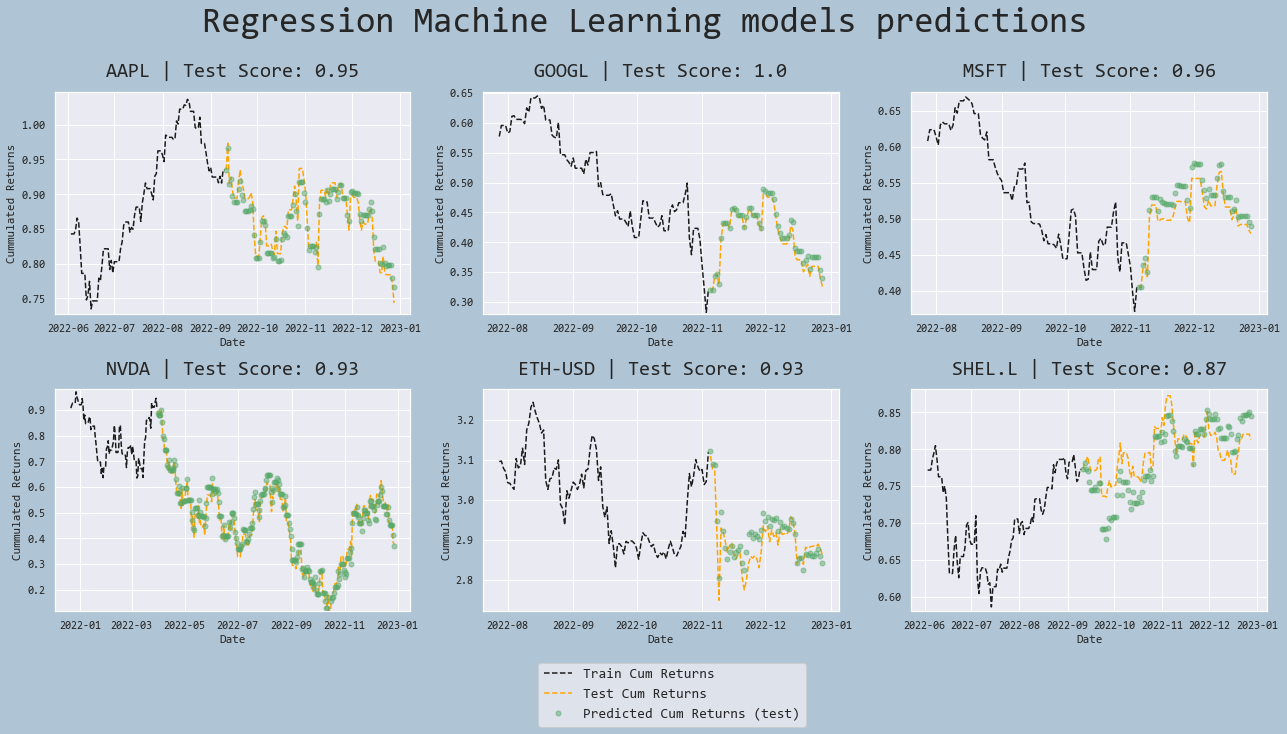

In [422]:
fig,ax = plt.subplots(figsize = (18,9))
fig.suptitle("Regression Machine Learning models predictions", fontsize = 35, y = 1.001)
ax1 = plt.subplot(2,3,1)
ax2 = plt.subplot(2,3,2)
ax3 = plt.subplot(2,3,3)
ax4 = plt.subplot(2,3,4)
ax5 = plt.subplot(2,3,5)
ax6 = plt.subplot(2,3,6)

ax_plot("AAPL", ax1, plot_features = False)
ax_plot("GOOGL", ax2, plot_features = False)
ax_plot("MSFT", ax3, plot_features = False)
ax_plot("NVDA", ax4, plot_features = False)
ax_plot("ETH-USD", ax5, plot_features = False)
ax_plot("SHEL.L", ax6, plot_features = False)

lines = []
labels = []
for ax in fig.axes[:1]:
    line, label = ax.get_legend_handles_labels()
    lines.extend(line)
    labels.extend(label)

fig.legend(lines, labels, fontsize = 14, bbox_to_anchor = [0.63,-0.000001])
fig.tight_layout()
plt.show()

### Chart: Train-Test distributions validation

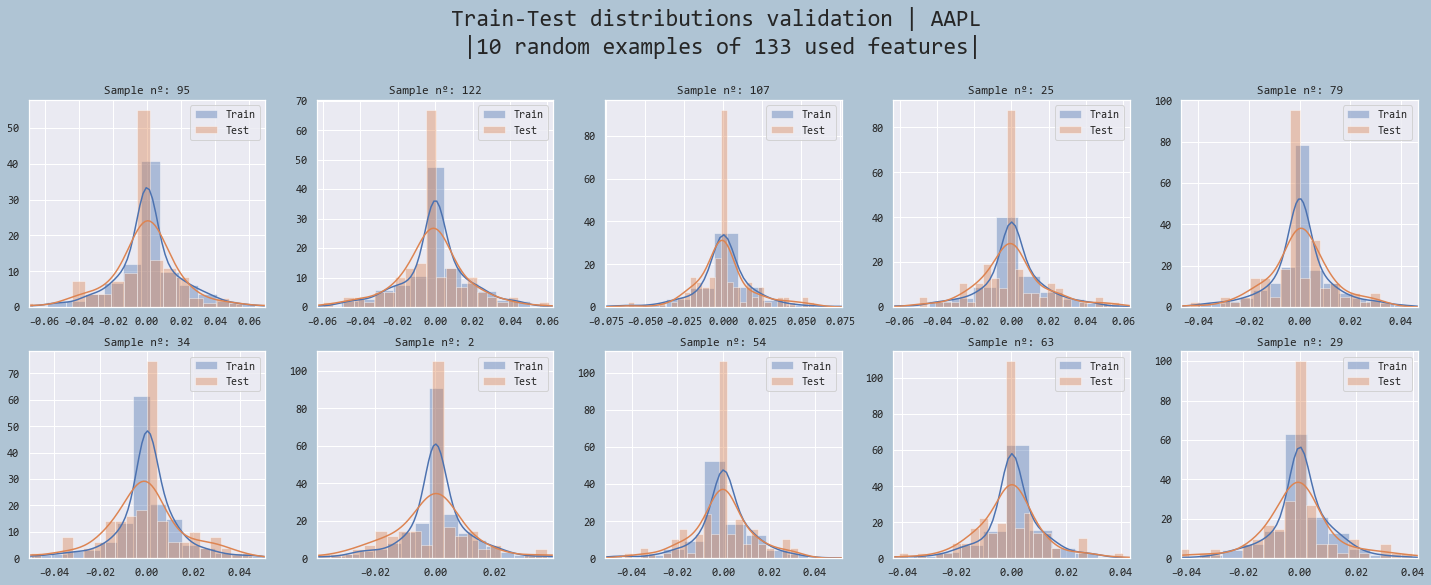

In [471]:
target_tic = "AAPL"
size = 10
rows = 2
cols = int(size/2)
samples = np.random.choice(X_train[target_tic].shape[1], size = size)
i = 0
fig, axes = plt.subplots(rows,cols,figsize = (20,8))
plt.suptitle(f"Train-Test distributions validation | {target_tic}\n |10 random examples of {X[target_tic].shape[1]} used features|", fontsize = 23, y = 1.01)
for row in range(rows):
    for col in range(cols):
        ax = axes[row][col]
        sns.distplot(X_train[target_tic][:,samples[i]], ax=ax, bins = 30, label = "Train")
        sns.distplot(X_test[target_tic][:,samples[i]], ax=ax, bins = 30, label = "Test")
        ax.legend()
        ax.set_xlim(-np.std(X_train[target_tic][:,samples[i]])*3, np.std(X_train[target_tic][:,samples[i]])*3)
        ax.set_title(f"Sample nº: {samples[i]}")
        ax.set_ylabel(None)
        i +=1
plt.tight_layout()
plt.show()

### Chart: Learning Curves MSE - R2

In [604]:
def plot_learning_curves(target_tic, X, y, ax1, ax2, poly = "", ylim11 = None, ylim12 = None, ylim21 = None, ylim22 = None, title = "Learning Curve"):
    """
    Input:
        * model
        * X
        * y
        * train test split size (default = 0.3)
        * ax, if you want to plot it in a combined plot (default = "")
        * poly, if you want to use a polynomial model (default = "")
        * ylim1 (default = None)
        * ylim2 (default = None)
    """
    model = estimator[target_tic]
    test_size = best_models1.loc[(best_models1.index.get_level_values(0) == target_tic)].index.get_level_values(4)[0]

    X_train, X_test, y_train, y_test = train_test_split(X[target_tic], y[target_tic], test_size = test_size, random_state = 42)
    train_errors, test_errors = [], []
    train_scores, test_scores = [], []
    
    for m in range(1, len(X_train)):
        if poly == "":
            model.fit(X_train[:m], y_train[:m])
        else:
            X_poly = poly.fit_transform(X_train[:m])
            model.fit(X_poly, y_train[:m])
            
        y_train_predict = model.predict(X_train[:m])
        y_test_predict = model.predict(X_test)
            
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        test_errors.append(mean_squared_error(y_test, y_test_predict))
        
        train_scores.append(r2_score(y_train[:m], y_train_predict))
        test_scores.append(r2_score(y_test, y_test_predict))
    
    ax1.set_title(f"{target_tic} mean squared error", font = "consolas", fontsize = 20, pad = 15)
    ax1.plot(np.sqrt(train_errors), "r-", linewidth=2, label="Train mse")
    ax1.plot(np.sqrt(test_errors), "b-", linewidth=3, label="Test mse")
    ax1.set_ylim(ylim11,ylim12)
    ax1.set_ylabel("MSE", fontsize = 12)
    ax1.annotate(f"{np.round(np.sqrt(test_errors[-1]),3)}", [len(test_errors)*.92,np.sqrt(test_errors[-1])*1.5], fontsize = 16, color = "g", fontweight = "bold",
                bbox = dict(facecolor = "white", edgecolor = "darkgreen", linewidth = 0.5))
    
    ax2.set_title(f"{target_tic} r2 score", font = "consolas", fontsize = 20, pad = 15)
    ax2.plot(train_scores, c = "coral", linewidth=2, label="Train r2 score")
    ax2.plot(test_scores, c = "skyblue", linewidth=3, label="Test r2 score")
    ax2.set_ylim(ylim21,ylim22)
    ax2.set_ylabel("r2 score", fontsize = 12)
    ax2.annotate(f"{np.round(test_scores[-1],2)}", [len(test_scores)*.95,test_scores[-1]*.87], fontsize = 16, color = "g", fontweight = "bold",
                bbox = dict(facecolor = "white", edgecolor = "darkgreen", linewidth = 0.5))

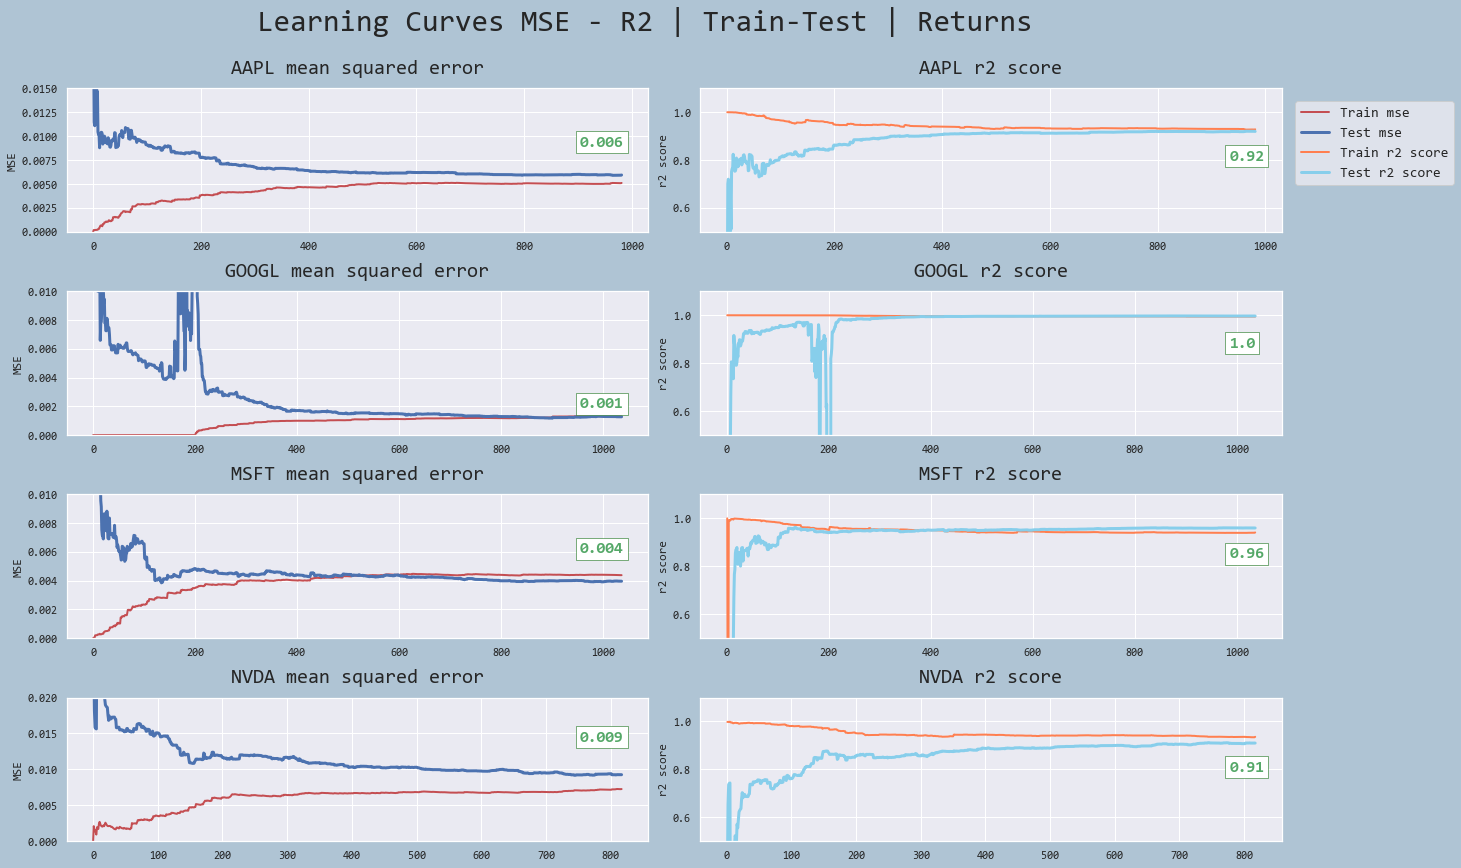

In [605]:
fig,ax = plt.subplots(figsize = (18,12))
fig.suptitle("Learning Curves MSE - R2 | Train-Test | Returns", fontsize = 30, y = 1.001)

ax1 = plt.subplot(4,2,1)
ax2 = plt.subplot(4,2,2)
ax3 = plt.subplot(4,2,3)
ax4 = plt.subplot(4,2,4)
ax5 = plt.subplot(4,2,5)
ax6 = plt.subplot(4,2,6)
ax7 = plt.subplot(4,2,7)
ax8 = plt.subplot(4,2,8)

plot_learning_curves("AAPL", X, y, ax1, ax2, ylim11 = 0, ylim12 = 0.015, ylim21 = 0.5, ylim22 = 1.1)
plot_learning_curves("GOOGL", X, y, ax3, ax4, ylim11 = 0, ylim12 = 0.01, ylim21 = 0.5, ylim22 = 1.1)
plot_learning_curves("MSFT", X, y, ax5, ax6, ylim11 = 0, ylim12 = 0.01, ylim21 = 0.5, ylim22 = 1.1)
plot_learning_curves("NVDA", X, y, ax7, ax8, ylim11 = 0, ylim12 = 0.02, ylim21 = 0.5, ylim22 = 1.1)

lines = []
labels = []
for ax in fig.axes[:2]:
    line, label = ax.get_legend_handles_labels()
    lines.extend(line)
    labels.extend(label)

fig.legend(lines, labels, fontsize = 14, bbox_to_anchor = [1.13,0.9])
fig.tight_layout()
plt.show()